# ThinkBrake: Result Analysis

## Import and Configs

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
import seaborn as sns
from matplotlib.patches import Patch

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (14, 7),
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.family": "sans-serif",
    }
)

model_colors = sns.color_palette("dark", 8)
benchmark_colors = sns.color_palette("dark", 10)
method_palette = {
    "Baseline": "#2C3E50",
    "Thinkless": "#E74C3C",
    "ThinkBrake": "#3498DB",
}
threshold_palette = sns.color_palette("Blues", 6)[1:]
bar_colors = [
    "#1A5276",
    "#2980B9",
    "#5499C7",
    "#7FB3D5",
    "#A9CCE3",
    "#F5B7B1",
    "#F1948A",
    "#EC7063",
    "#E74C3C",
    "#B03A2E",
]
line_colors = [
    "#1A5276",
    "#B03A2E",
    "#1E8449",
    "#7D3C98",
    "#B9770E",
    "#117A65",
    "#6C3483",
    "#1F618D",
]

markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

model_name_map = {}
short_names = {}

In [2]:
def calc_subplot_layout(n_items, max_cols=4):
    if n_items == 0:
        return 1, 1, (6, 4)

    cols = min(n_items, max_cols)
    rows = math.ceil(n_items / cols)
    fig_width = 5.5 * cols
    fig_height = 4.5 * rows
    return rows, cols, (fig_width, fig_height)


def create_dynamic_subplots(n_items, max_cols=4, sharey=False):
    rows, cols, figsize = calc_subplot_layout(n_items, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)

    if n_items == 1:
        axes = np.array([axes])
    else:
        axes = np.array(axes).flatten()

    for i in range(n_items, len(axes)):
        axes[i].set_visible(False)

    return fig, axes


def add_value_labels(ax, bars, fmt=".1f", rotation=0, fontsize=9, offset=0.5):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f"{height:{fmt}}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=fontsize,
                rotation=rotation,
            )


def format_model_name(name, short_names):
    return short_names.get(name, name.split("/")[-1])


def load_detailed_results(model_dir, benchmark, method="rollout"):
    base_path = Path(f"../output/{model_dir}")
    math_benchmarks = ["gsm8k", "math500", "aime2024", "aime2025"]
    general_benchmarks = ["gpqa-diamond", "arc-challenge"]

    if benchmark in math_benchmarks:
        category = "math"
    elif benchmark in general_benchmarks:
        category = "general"
    else:
        return None

    if method == "rollout":
        file_path = base_path / category / "rollout" / f"{benchmark}_result.jsonl"
    else:
        file_path = (
            base_path / category / "thinkbrake" / method / f"{benchmark}_result.jsonl"
        )

    if not file_path.exists():
        return None

    results = []
    with open(file_path, "r") as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    return results

## Load Dataset

In [3]:
INCLUDE_MODELS = [
    "Qwen_Qwen3-4B-Thinking-2507",
    "Qwen_Qwen3-4B",
    "Qwen_Qwen3-14B",
    "Qwen_Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B",
    "microsoft_phi-4-reasoning",
]

INCLUDE_BENCHMARKS = [
    "gsm8k",
    "math500",
    "aime2024",
    "aime2025",
    "gpqa-diamond",
    # "arc-challenge",
    # "bfcl-v1",
    # "bfcl-v2",
    # "meta-tool",
]

INCLUDE_THRESHOLDS = [
    "0.1",
    "0.25",
    "1.0",
    "2.5",
]

In [4]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
METRICS_PATH = PROJECT_ROOT / "metrics_summary.jsonl"

rows = []
with open(METRICS_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))

df_metrics = pd.DataFrame(rows)
df_metrics = df_metrics[df_metrics["sub_category"].isna()].copy()
df_metrics = df_metrics[df_metrics["model"].isin(INCLUDE_MODELS)].copy()
df_metrics = df_metrics[df_metrics["benchmark"].isin(INCLUDE_BENCHMARKS)].copy()

benchmarks = INCLUDE_BENCHMARKS
thresholds = sorted(INCLUDE_THRESHOLDS, key=lambda x: float(x))


def _model_key(model_dir: str) -> str:
    return model_name_map.get(model_dir, model_dir)


rollout_data = {}
thinkbrake_data = {}

df_rollout = df_metrics[
    (df_metrics["method"] == "rollout") & (df_metrics["threshold"].isna())
]
for _, r in df_rollout.iterrows():
    mk = _model_key(r["model"])
    rollout_data.setdefault(mk, {})
    rollout_data[mk][r["benchmark"]] = {
        "accuracy": float(r.get("accuracy", 0.0) or 0.0),
        "avg_token_length": float(r.get("avg_token_length", 0.0) or 0.0),
    }

df_tb = df_metrics[
    (df_metrics["method"] == "thinkbrake") & (~df_metrics["threshold"].isna())
]
for _, r in df_tb.iterrows():
    mk = _model_key(r["model"])
    try:
        t = float(r["threshold"])
    except Exception:
        continue
    t_str = str(t)
    if t_str not in INCLUDE_THRESHOLDS:
        continue
    thinkbrake_data.setdefault(mk, {})
    thinkbrake_data[mk].setdefault(r["benchmark"], {})
    thinkbrake_data[mk][r["benchmark"]][f"threshold_{t_str}"] = {
        "accuracy": float(r.get("accuracy", 0.0) or 0.0),
        "avg_token_length": float(r.get("avg_token_length", 0.0) or 0.0),
    }

filtered_rollout_data = {
    k: v
    for k, v in rollout_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
filtered_thinkbrake_data = {
    k: v
    for k, v in thinkbrake_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
baseline_data = filtered_rollout_data

print("Data loaded successfully!")

Data loaded successfully!


## Load Detailed Results Data

In [5]:
def load_all_detailed_results(model_dirs, benchmarks, best_threshold="0.25"):
    all_results = {}

    for model_dir in model_dirs:
        all_results[model_dir] = {}
        for benchmark in benchmarks:
            rollout_results = load_detailed_results(model_dir, benchmark, "rollout")
            thinkbrake_results = load_detailed_results(
                model_dir, benchmark, f"threshold_{best_threshold}"
            )

            if rollout_results and thinkbrake_results:
                all_results[model_dir][benchmark] = {
                    "rollout": rollout_results,
                    "thinkbrake": thinkbrake_results,
                }

    return all_results

In [6]:
BEST_THRESHOLD = 0.1
detailed_results = load_all_detailed_results(
    INCLUDE_MODELS, INCLUDE_BENCHMARKS, BEST_THRESHOLD
)

## Confusion Matrix

In [7]:
from math_verify import parse, verify
import re


def extract_multiple_choice_answer(response: str) -> str:
    patterns = [
        r'["\*]*answer["\*]*\s*[:=]\s*["\']?([A-Da-d])["\']?',
        r"(?:the\s+)?answer\s+is[:\s]*([A-Da-d])\b",
        r"final\s+answer[:\s]*([A-Da-d])\b",
        r"(?:choice|option)[:\s]*([A-Da-d])\b",
        r"\b([A-Da-d])\s*$",
    ]

    for pattern in patterns:
        matches = re.findall(pattern, response, re.IGNORECASE)
        if matches:
            return matches[-1].upper()

    standalone_matches = re.findall(r"\b([A-Da-d])\b", response)
    if standalone_matches:
        return standalone_matches[-1].upper()

    return ""


def verify_multiple_choice(ground_truth: str, predicted: str) -> bool:
    """Verify if the predicted multiple choice answer matches the ground truth."""
    if not predicted:
        return False
    return ground_truth.upper().strip() == predicted.upper().strip()


def evaluate_item(item: dict, is_multiple_choice: bool) -> bool:
    """
    Evaluate a single item using the same logic as evaluate.py
    """
    if is_multiple_choice:
        ground_truth = item["answer"]
        predicted = extract_multiple_choice_answer(item["response"])
        return verify_multiple_choice(ground_truth, predicted)
    else:
        # Math evaluation using math_verify
        try:
            ground_truth = parse(f"${item['answer']}$")
            predicted = parse(item["response"])
            return verify(ground_truth, predicted)
        except Exception:
            return False


def compute_confusion_matrix(rollout_results, thinkbrake_results, benchmark):
    """Compute confusion matrix comparing rollout (baseline) vs thinkbrake results"""
    rollout_dict = {r["id"]: r for r in rollout_results}
    thinkbrake_dict = {r["id"]: r for r in thinkbrake_results}

    # Determine if it's a multiple choice benchmark
    general_benchmarks = ["gpqa-diamond", "mmlu-redux"]
    is_multiple_choice = benchmark in general_benchmarks

    both_correct = 0
    only_rollout_correct = 0
    only_thinkbrake_correct = 0
    both_wrong = 0

    # Find common IDs
    common_ids = set(rollout_dict.keys()) & set(thinkbrake_dict.keys())

    for pid in common_ids:
        rollout_item = rollout_dict[pid]
        tb_item = thinkbrake_dict[pid]

        # Evaluate using the same method as evaluate.py
        rollout_correct = evaluate_item(rollout_item, is_multiple_choice)
        tb_correct = evaluate_item(tb_item, is_multiple_choice)

        if rollout_correct and tb_correct:
            both_correct += 1
        elif rollout_correct and not tb_correct:
            only_rollout_correct += 1
        elif not rollout_correct and tb_correct:
            only_thinkbrake_correct += 1
        else:
            both_wrong += 1

    return (
        both_correct,
        only_rollout_correct,
        only_thinkbrake_correct,
        both_wrong,
        len(common_ids),
    )

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/64400915.py:94: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/64400915.py:94: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


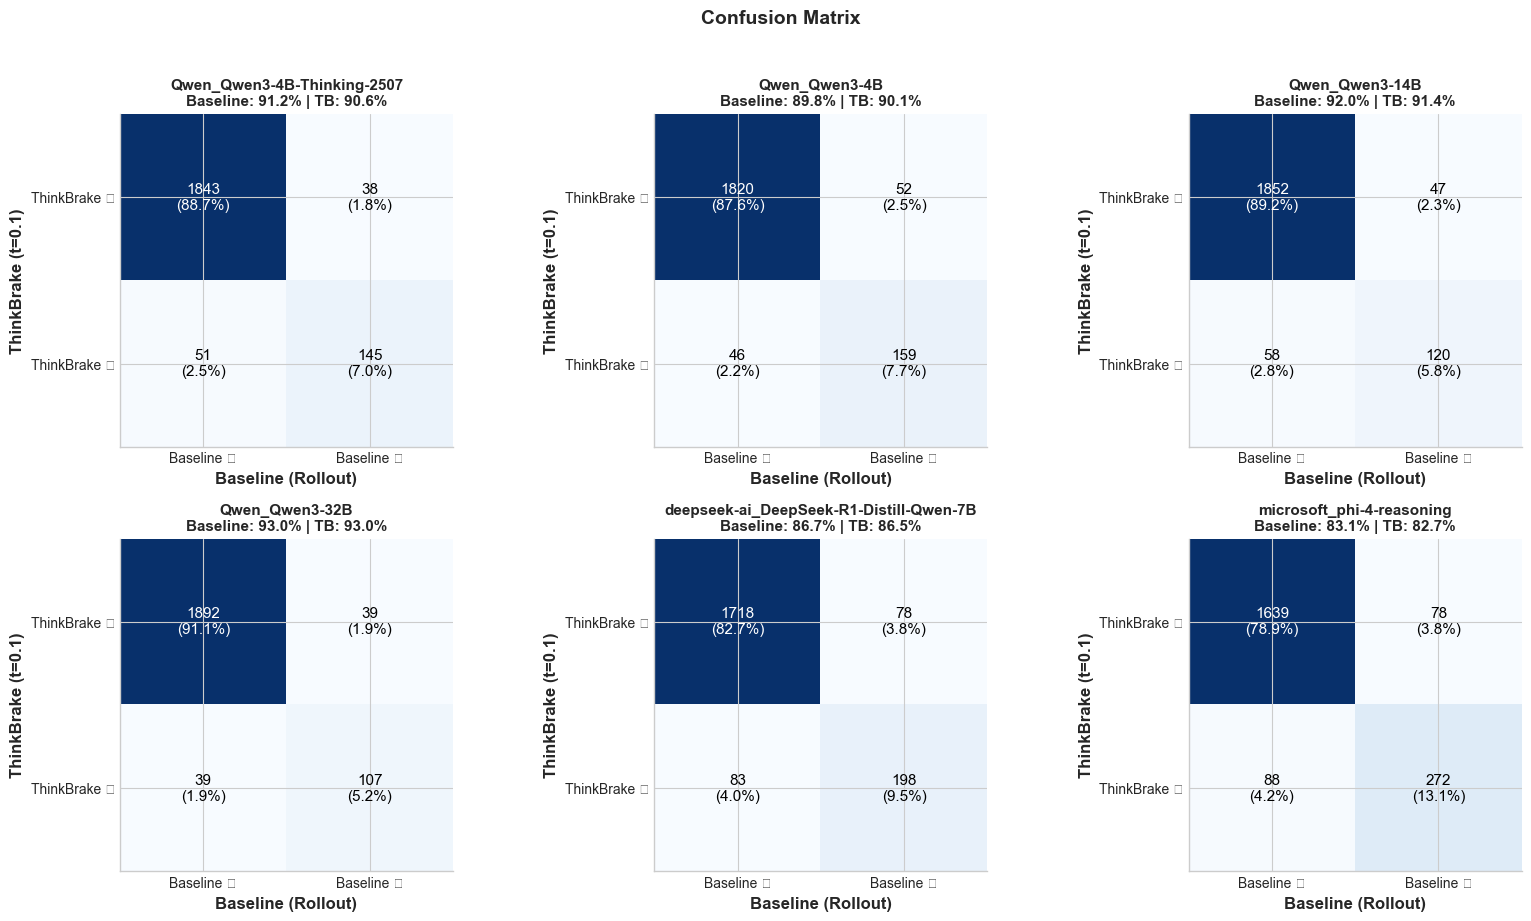

In [8]:
confusion_data = {}

for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)
    confusion_data[display_name] = {}

    for benchmark, data in benchmarks_data.items():
        if data["rollout"] and data["thinkbrake"]:
            cm = compute_confusion_matrix(
                data["rollout"], data["thinkbrake"], benchmark
            )
            confusion_data[display_name][benchmark] = {
                "both_correct": cm[0],
                "only_rollout": cm[1],
                "only_thinkbrake": cm[2],
                "both_wrong": cm[3],
                "total": cm[4],
            }


n_models = len([m for m in confusion_data if confusion_data[m]])
if n_models > 0:
    fig, axes = create_dynamic_subplots(n_models, max_cols=3)

    for idx, (model_name, bench_data) in enumerate(confusion_data.items()):
        if not bench_data:
            continue
        ax = axes[idx]

        total_both_correct = sum(d["both_correct"] for d in bench_data.values())
        total_only_rollout = sum(d["only_rollout"] for d in bench_data.values())
        total_only_tb = sum(d["only_thinkbrake"] for d in bench_data.values())
        total_both_wrong = sum(d["both_wrong"] for d in bench_data.values())
        total = sum(d["total"] for d in bench_data.values())

        # Calculate accuracies
        baseline_acc = (
            (total_both_correct + total_only_rollout) / total * 100 if total > 0 else 0
        )
        tb_acc = (total_both_correct + total_only_tb) / total * 100 if total > 0 else 0

        # Create confusion matrix
        # Rows: ThinkBrake (Correct/Wrong), Cols: Baseline (Correct/Wrong)
        cm = np.array(
            [
                [
                    total_both_correct,
                    total_only_tb,
                ],  # TB Correct: Both correct, Only TB correct
                [
                    total_only_rollout,
                    total_both_wrong,
                ],  # TB Wrong: Only Baseline correct, Both wrong
            ]
        )

        # Plot heatmap
        im = ax.imshow(cm, cmap="Blues")

        # Add labels - fixed orientation
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Baseline ✓", "Baseline ✗"])
        ax.set_yticklabels(["ThinkBrake ✓", "ThinkBrake ✗"])
        ax.set_xlabel("Baseline (Rollout)", fontweight="bold")
        ax.set_ylabel(f"ThinkBrake (t={BEST_THRESHOLD})", fontweight="bold")

        # Add text annotations
        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / total * 100 if total > 0 else 0
                text = ax.text(
                    j,
                    i,
                    f"{cm[i, j]}\n({pct:.1f}%)",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        ax.set_title(
            f"{model_name}\nBaseline: {baseline_acc:.1f}% | TB: {tb_acc:.1f}%",
            fontsize=11,
            fontweight="bold",
        )

    plt.suptitle(
        "Confusion Matrix",
        fontsize=14,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

## Confusion Matrix by Benchmark

각 벤치마크별로 Baseline과 ThinkBrake의 정답 일치/불일치 패턴을 분석합니다.

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


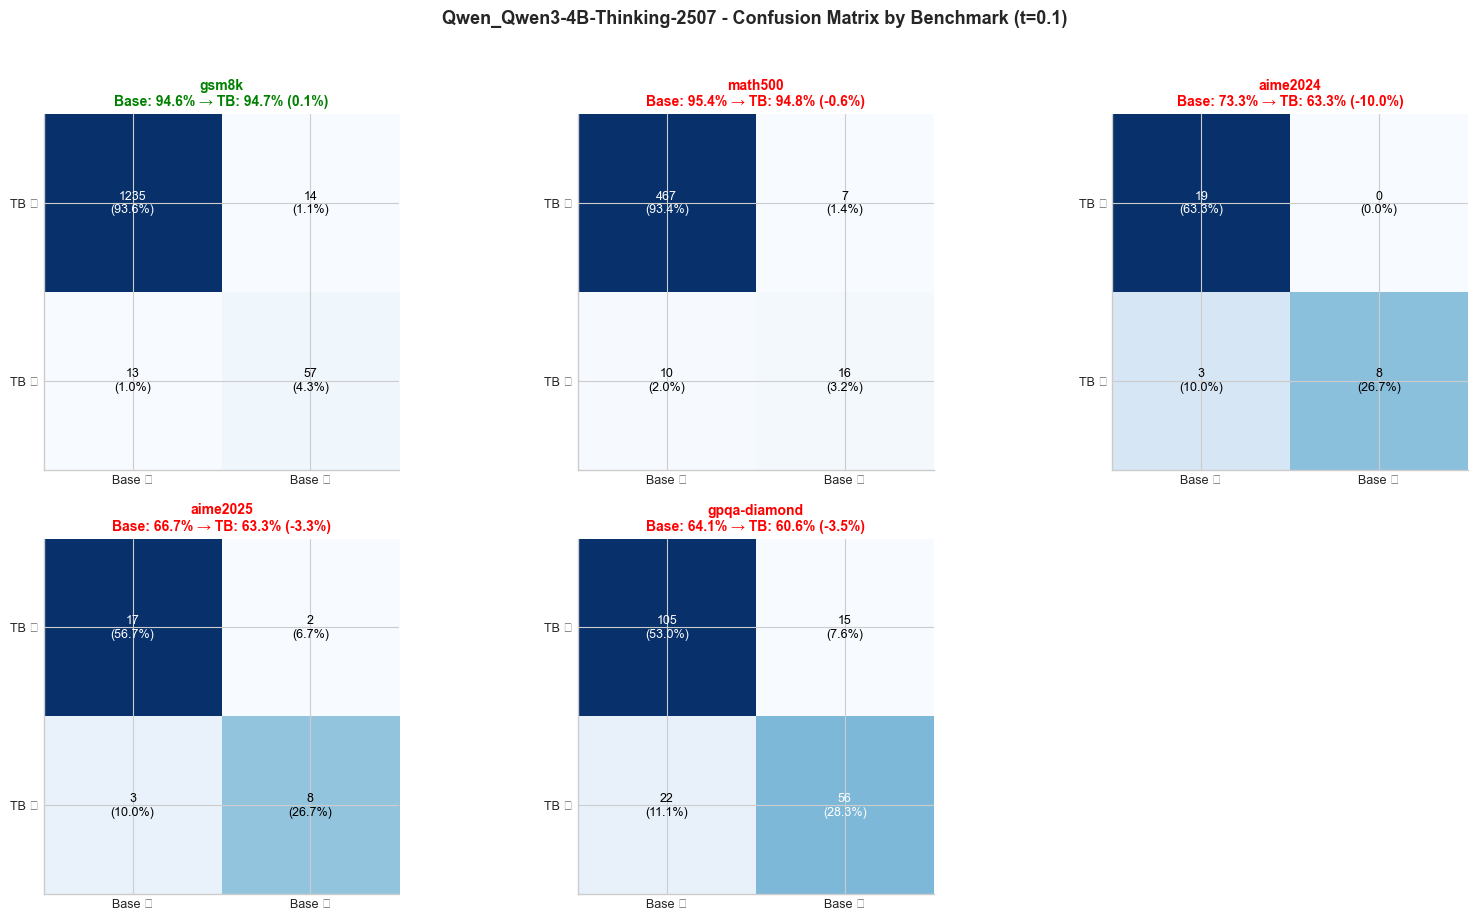

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


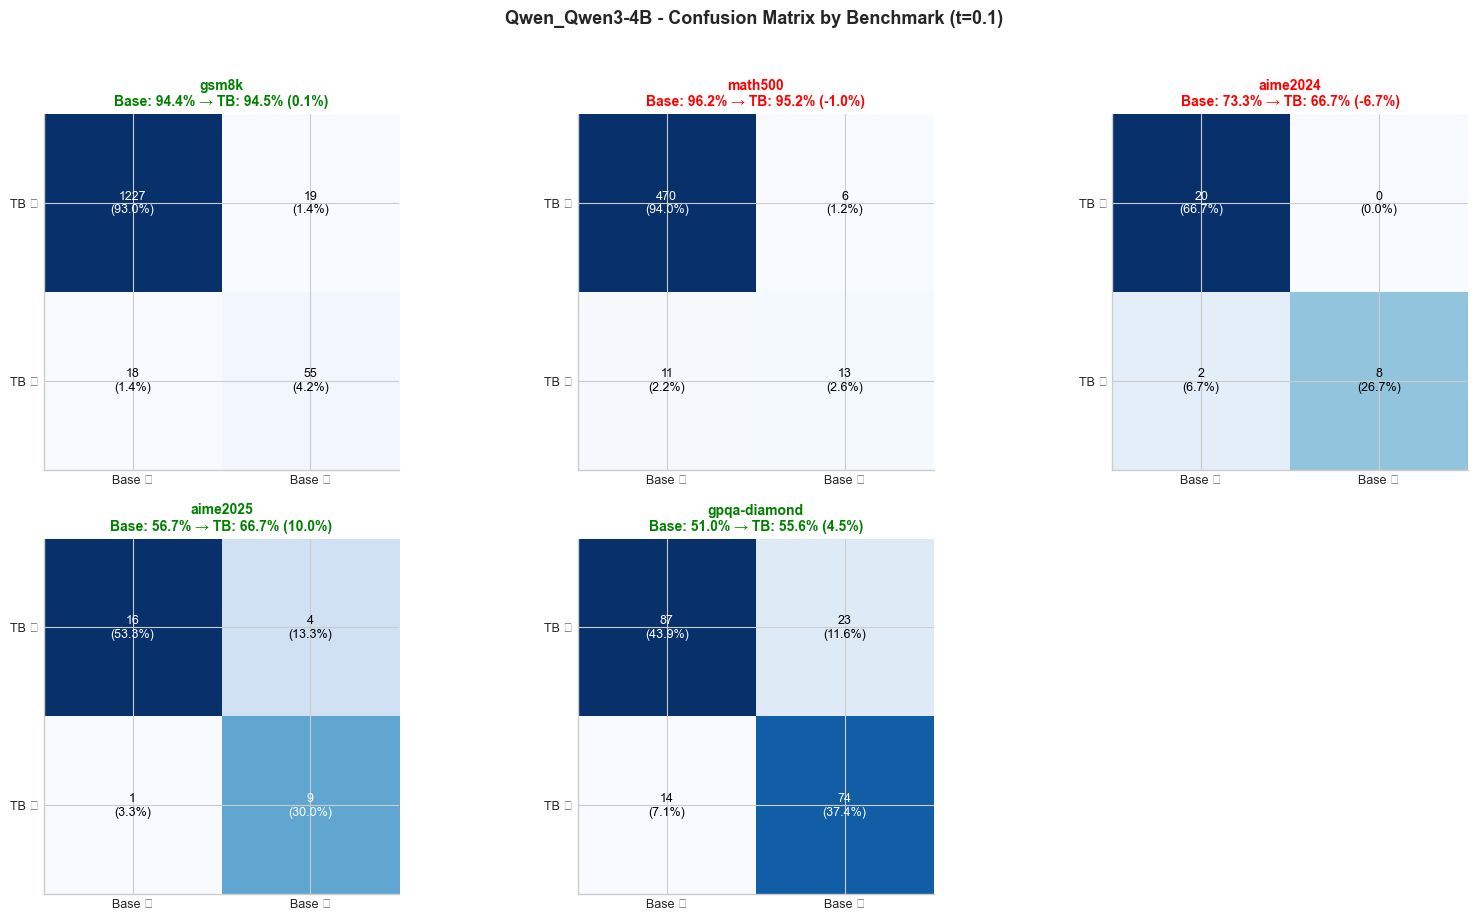

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


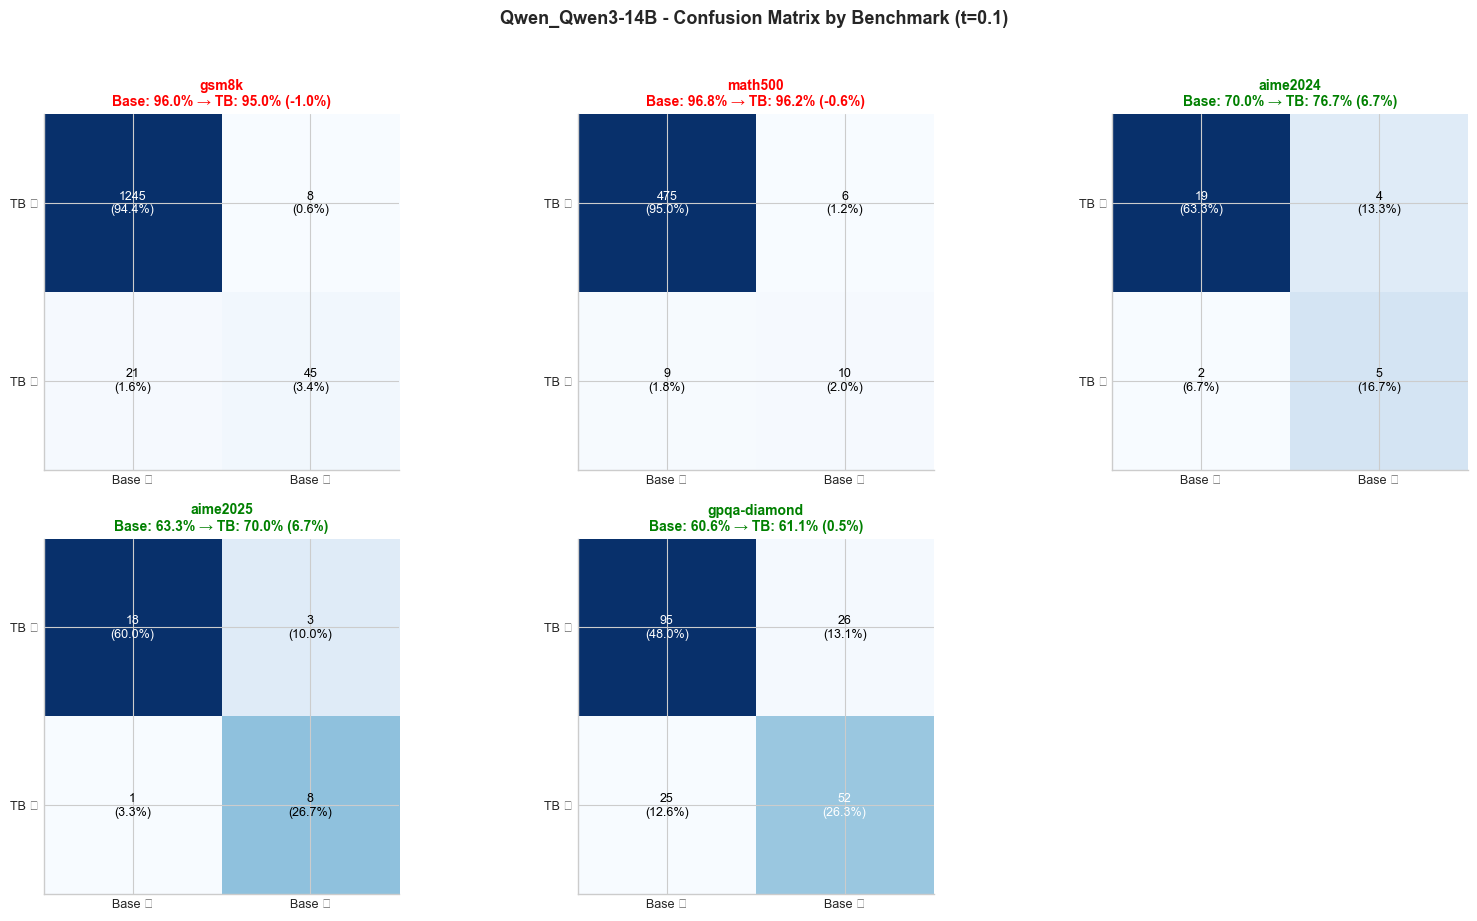

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


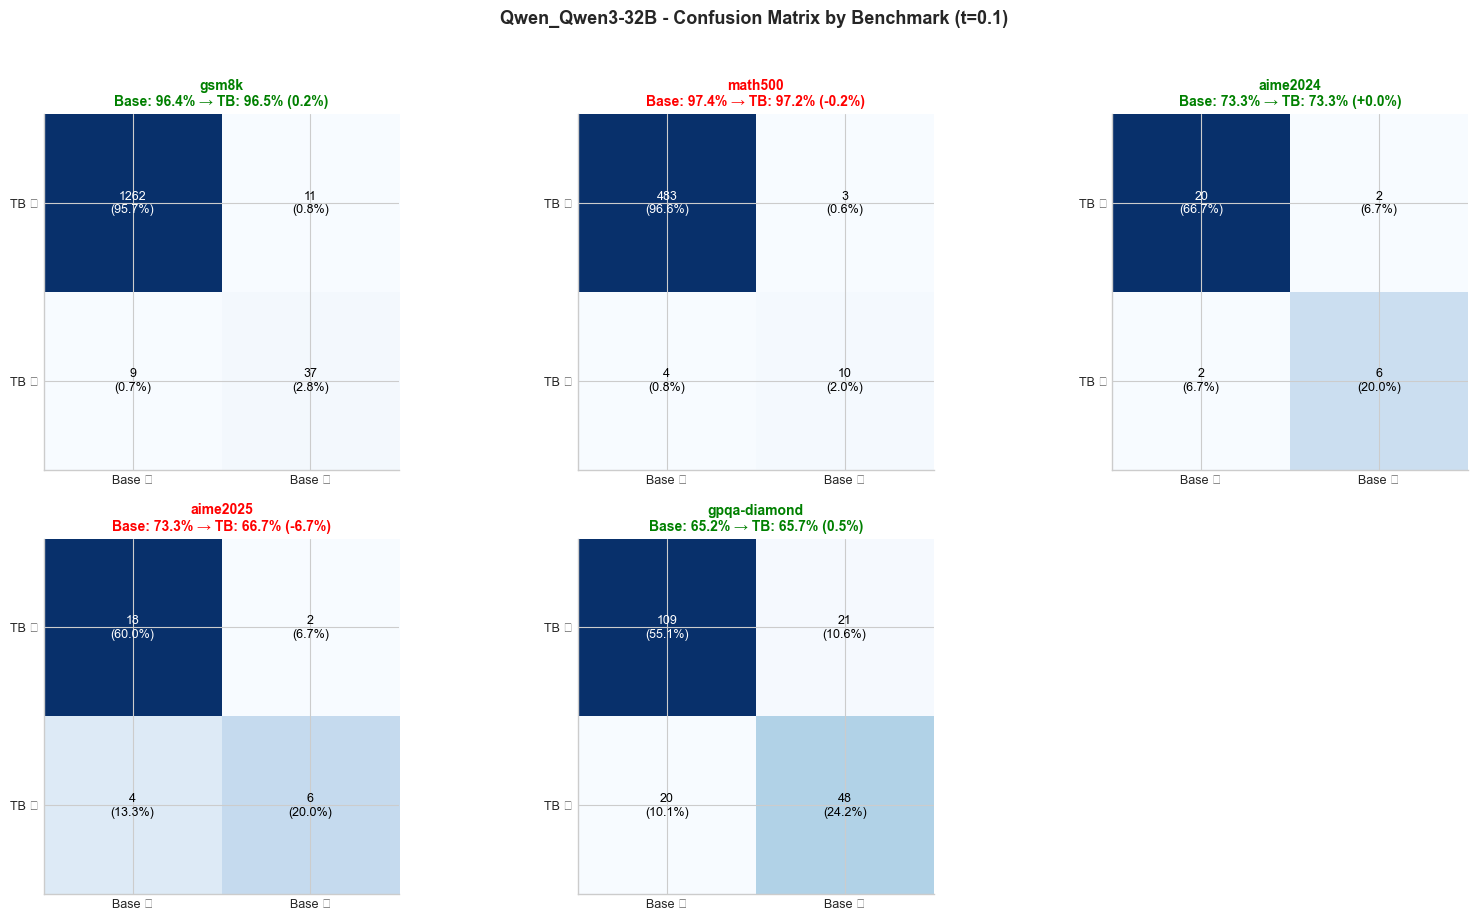

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


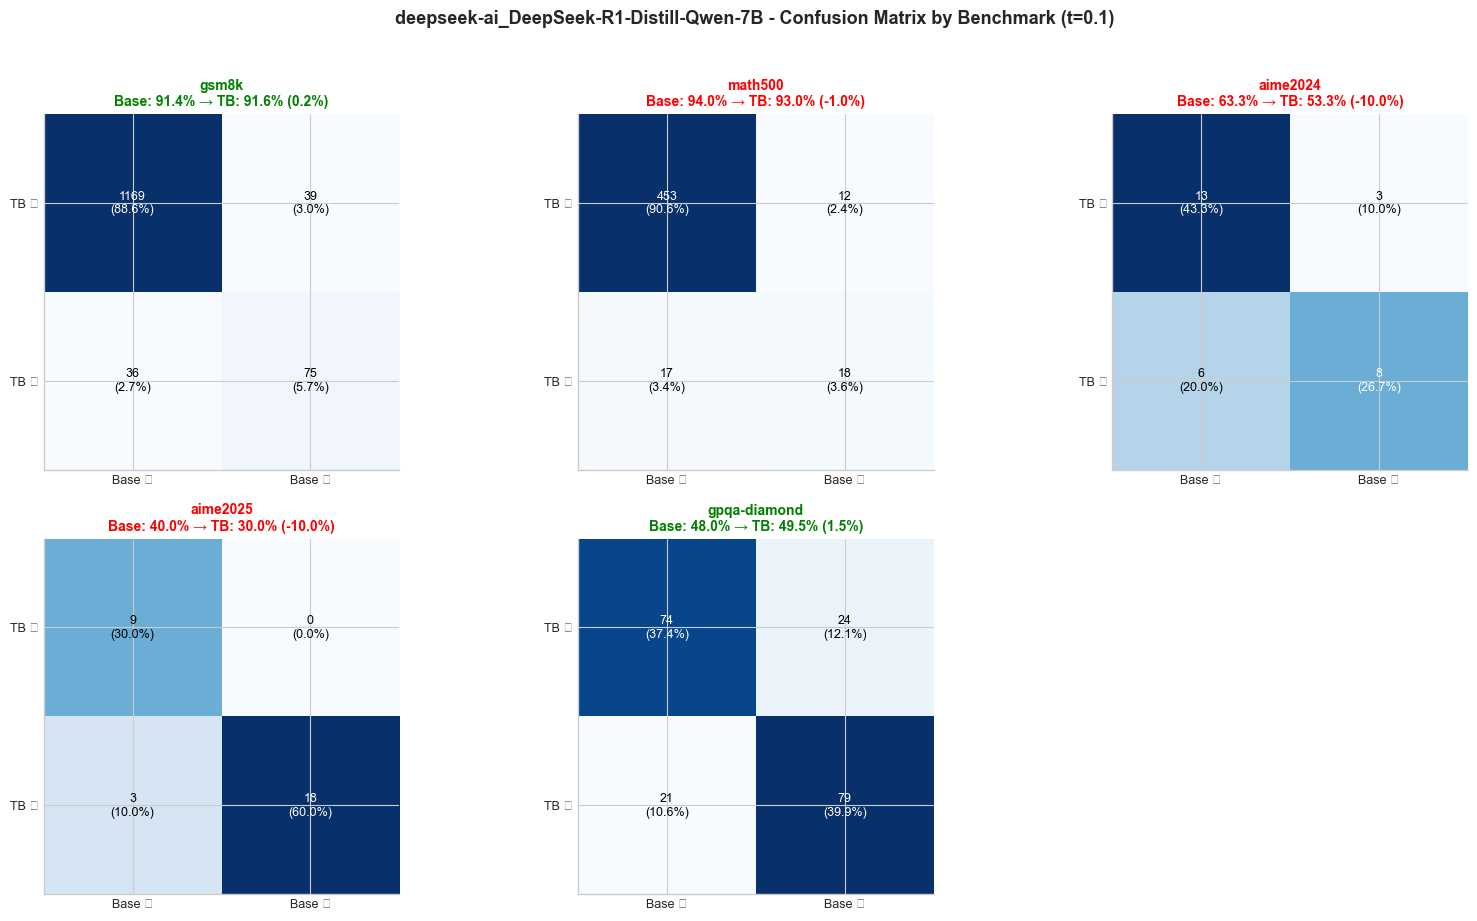

/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/kx/wqncr7cn4ss8bnrxq07f0pz40000gn/T/ipykernel_74322/3002055241.py:72: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ssj/dev/thinkbrake_analysis/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


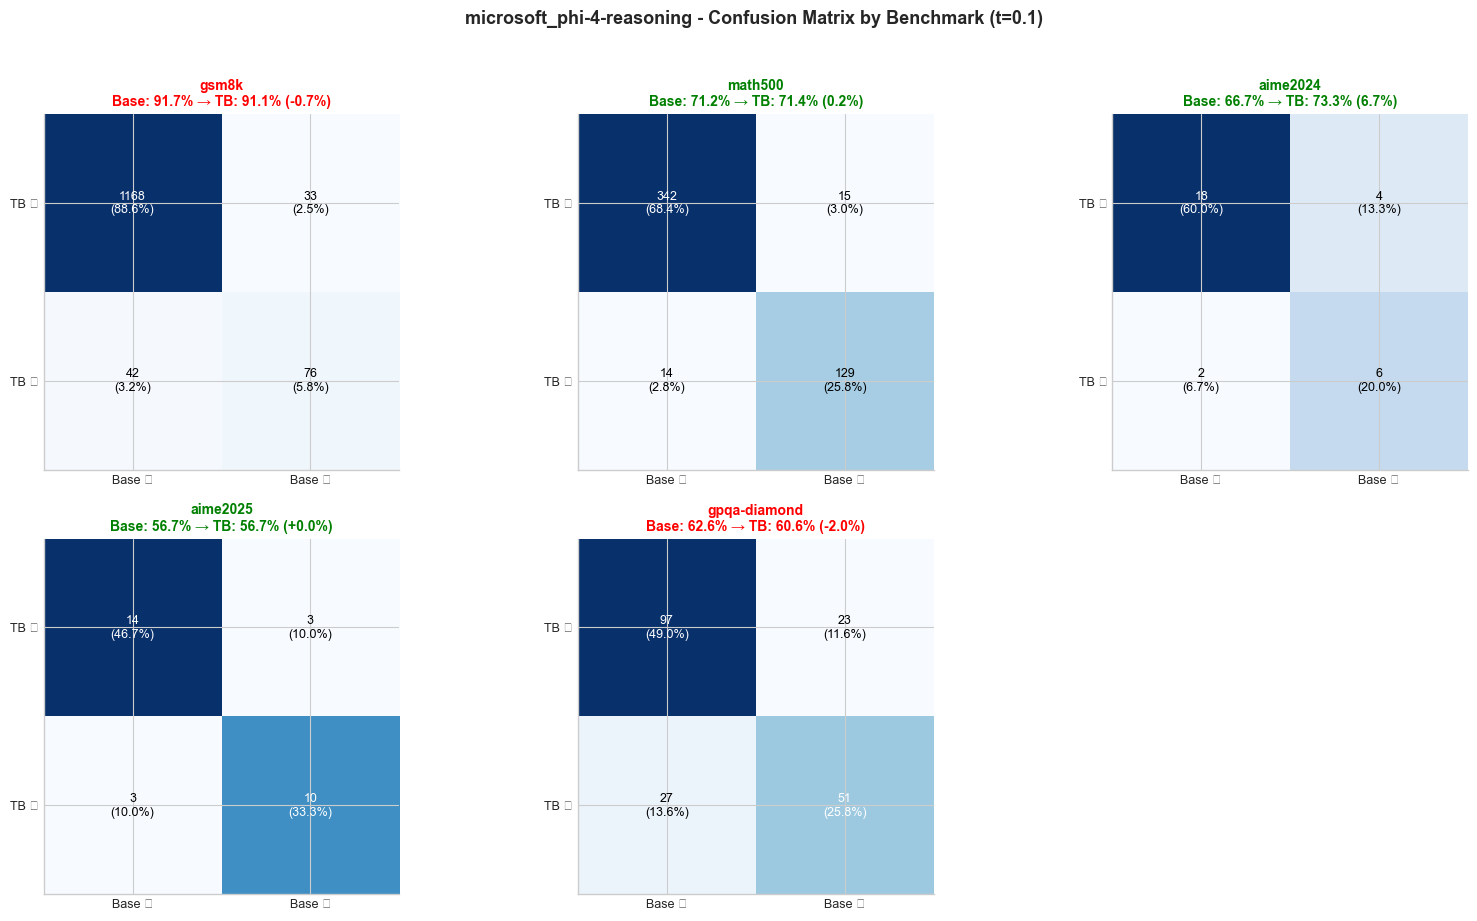

In [9]:
for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)

    available_benchmarks = [b for b in INCLUDE_BENCHMARKS if b in benchmarks_data]
    n_benchmarks = len(available_benchmarks)

    if n_benchmarks == 0:
        continue

    fig, axes = create_dynamic_subplots(n_benchmarks, max_cols=3)

    for idx, benchmark in enumerate(available_benchmarks):
        ax = axes[idx]
        data = benchmarks_data[benchmark]

        if not data["rollout"] or not data["thinkbrake"]:
            continue

        cm_result = compute_confusion_matrix(
            data["rollout"], data["thinkbrake"], benchmark
        )
        both_correct, only_rollout, only_tb, both_wrong, total = cm_result

        baseline_acc = (both_correct + only_rollout) / total * 100 if total > 0 else 0
        tb_acc = (both_correct + only_tb) / total * 100 if total > 0 else 0
        diff = tb_acc - baseline_acc

        cm = np.array(
            [
                [both_correct, only_tb],
                [only_rollout, both_wrong],
            ]
        )

        # Plot heatmap
        im = ax.imshow(cm, cmap="Blues")

        # Add labels
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Base ✓", "Base ✗"], fontsize=9)
        ax.set_yticklabels(["TB ✓", "TB ✗"], fontsize=9)

        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / total * 100 if total > 0 else 0
                ax.text(
                    j,
                    i,
                    f"{cm[i, j]}\n({pct:.1f}%)",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        diff_color = "green" if diff >= 0 else ("red" if diff < 0 else "black")
        diff_sign = "+" if diff == 0 else ""
        ax.set_title(
            f"{benchmark}\nBase: {baseline_acc:.1f}% → TB: {tb_acc:.1f}% ({diff_sign}{diff:.1f}%)",
            fontsize=10,
            fontweight="bold",
            color=diff_color,
        )

    plt.suptitle(
        f"{display_name} - Confusion Matrix by Benchmark (t={BEST_THRESHOLD})",
        fontsize=13,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()